# Recorte 2014 - 2016 -> Ação

In [31]:
# Importando bibliotecas necessárias para a construção de grafos
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *
import pandas as pd
import numpy as np
import csv
import ast
import cpnet
from graph_tool import spectral
import seaborn as sns
import regression as reg
import cpnet

from scipy import stats
from matplotlib import pyplot as plt
from graph_tool import centrality
from graph_tool import spectral

In [32]:
df = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
df.dropna(subset=['Publisher'], inplace=True)
df_critic = df.loc[~df['Critic_Score'].isna()]
df_rating = df.loc[~df['Rating'].isna()]

In [33]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_critic_recortado = df_critic.loc[(df_critic['Year_of_Release'] >= 2014) & (df_critic['Year_of_Release'] <= 2016) & (df_critic['Genre'] == 'Action')] 
df_rating_recortado = df_rating.loc[(df_rating['Year_of_Release'] >= 2014) & (df_rating['Year_of_Release'] <= 2016) & (df_rating['Genre'] == 'Action')] 

In [35]:
df_critic_recortado.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
42,Grand Theft Auto V,PS4,2014.0,Action,Take-Two Interactive,3.96,6.31,0.38,1.97,12.61,97.0,66.0,8.3,2899.0,Rockstar North,M
165,Grand Theft Auto V,XOne,2014.0,Action,Take-Two Interactive,2.81,2.19,0.00,0.47,5.48,97.0,14.0,7.9,764.0,Rockstar North,M
231,Uncharted: The Nathan Drake Collection,PS4,2015.0,Action,Sony Computer Entertainment,2.07,1.71,0.08,0.76,4.62,86.0,78.0,8.1,1264.0,Bluepoint Games,T
295,Watch Dogs,PS4,2014.0,Action,Ubisoft,1.40,1.90,0.11,0.64,4.05,80.0,80.0,6.3,2996.0,Ubisoft Montreal,M
304,Assassin's Creed: Unity,PS4,2014.0,Action,Ubisoft,1.19,2.07,0.08,0.62,3.96,70.0,40.0,4.9,2050.0,"Ubisoft, Ubisoft Montreal",M


In [36]:
df_critic_recortado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 42 to 16696
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             231 non-null    object 
 1   Platform         231 non-null    object 
 2   Year_of_Release  231 non-null    float64
 3   Genre            231 non-null    object 
 4   Publisher        231 non-null    object 
 5   NA_Sales         231 non-null    float64
 6   EU_Sales         231 non-null    float64
 7   JP_Sales         231 non-null    float64
 8   Other_Sales      231 non-null    float64
 9   Global_Sales     231 non-null    float64
 10  Critic_Score     231 non-null    float64
 11  Critic_Count     231 non-null    float64
 12  User_Score       227 non-null    float64
 13  User_Count       227 non-null    float64
 14  Developer        231 non-null    object 
 15  Rating           225 non-null    object 
dtypes: float64(10), object(6)
memory usage: 30.7+ KB


In [7]:
df_critic_recortado.Year_of_Release.value_counts()

2015.0    253
2014.0    188
2016.0    177
Name: Year_of_Release, dtype: int64

In [8]:
publishers = df_critic_recortado["Publisher"].unique()

In [9]:
gamergate_action_graph = Graph(directed=False) # não-dirigido
gamergate_action_graph.add_vp('Publisher')
gamergate_action_graph.add_vp('Games_released')
gamergate_action_graph.add_ep('strength')

for pub in publishers:
    gamergate_action_graph.add_vertex(pub)
    gamergate_action_graph.get_vertex(pub)['Publisher'] = pub
    num_games = df_critic_recortado['Name'].loc[df_critic_recortado["Publisher"] == pub].nunique() 
    gamergate_action_graph.get_vertex(pub)['Games_released'] = num_games

In [10]:
sorted_years = list(range(2014, 2017))
print(sorted_years)

[2014, 2015, 2016]


In [11]:
df_list = []

margem = 4
for i in range(0, len(sorted_years), margem):
    df_list.append(df_recortado[df_recortado['Year_of_Release'].isin(sorted_years[i:i+margem])])

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


NameError: name 'df_recortado' is not defined

In [ ]:
publisher_platforms = []
for db in df_list:
    publisher_platforms.append(db.groupby('Platform')['Publisher'].unique().to_dict())

In [ ]:
for platform_dict in publisher_platforms:
    for platform, publishers in platform_dict.items():
        for i in range(len(publishers)):
            if i != len(publishers)-1:
                next_vertex = i+1
                while(next_vertex < len(publishers)):
                    if(publishers[i] != publishers[next_vertex] and not gamergate_action_graph.has_edge(publishers[i], publishers[next_vertex])):
                        gamergate_action_graph.add_edge(publishers[i], publishers[next_vertex])
                        gamergate_action_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] = 1
                        next_vertex += 1
                    else:
                        gamergate_action_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] += 1
                        next_vertex += 1

In [ ]:
print('número de vértices de g:', gamergate_action_graph.num_vertices())

In [ ]:
print('número de arestaas de g:', gamergate_action_graph.num_edges())

In [ ]:
gt_save(gamergate_action_graph, 'gamergate_action_graph.net.gz')

In [ ]:
g = gt_load('gamergate_action_graph.net.gz')
g = gt_clean(g)
cc = centrality.closeness(g)
g.add_vp('closeness', cc)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'gamergate_action_sfdp.net.gz')

# Análise

In [37]:
sns.histplot(np.log(df_recortado['Global_Sales']))

NameError: name 'df_recortado' is not defined

# Reconhecimento X Sucesso

In [38]:
df_rec_suc = df_critic_recortado.copy()

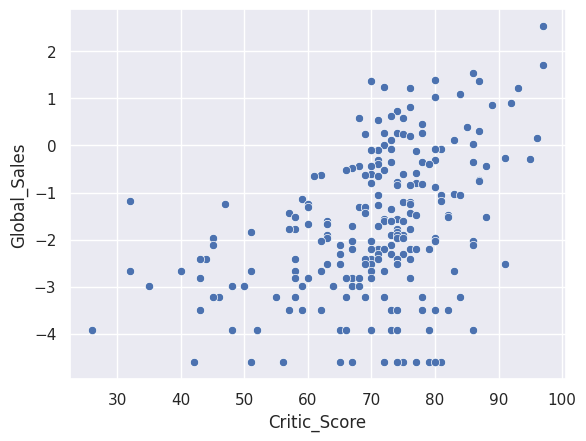

In [39]:
sns.scatterplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']));

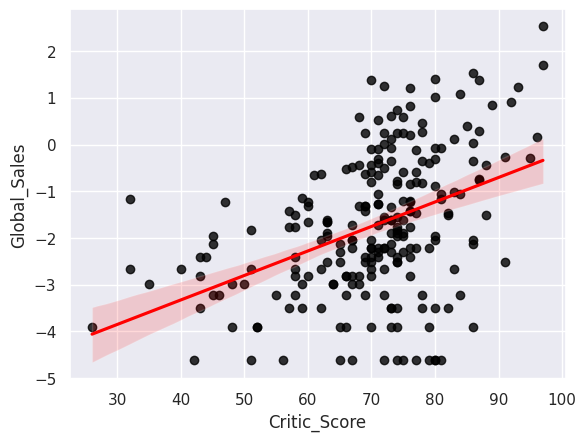

In [40]:
sns.regplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [41]:
result = reg.linear(data=df_rec_suc, formula='np.log(Global_Sales) ~ Critic_Score')

In [42]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.175
Model:                              OLS   Adj. R-squared:                  0.171
Method:                   Least Squares   F-statistic:                     48.53
Date:                  Fri, 25 Nov 2022   Prob (F-statistic):           3.42e-11
Time:                          20:16:46   Log-Likelihood:                -402.05
No. Observations:                   231   AIC:                             808.1
Df Residuals:                       229   BIC:                             815.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.4246      0.537    -10.105      0.000      -6.482      -4.367
Critic_Score     0.0524      0.008      6.966      0.000       0.038       0.067
==============================================================================
Omnibus:                        2.716   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.785
Skew:                          -0.253   Prob(JB):                        0.249
Kurtosis:                       2.817   Cond. No.                         420.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
result.micro_summary()

variable,coefficient,std error,p-value
Critic_Score,0.052426,0.007526,0.000000


In [44]:
result.nano_summary()

+0.052 (0.008) ***


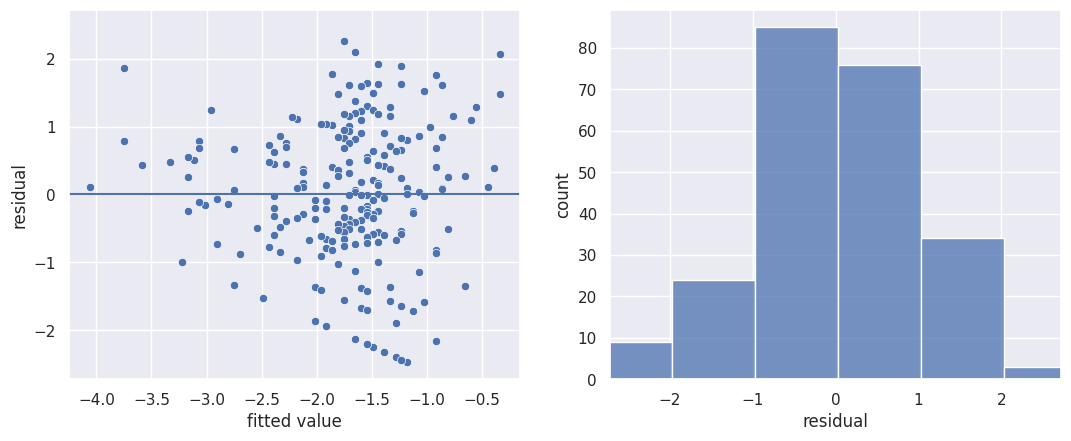

In [45]:
result.plot_residuals()

# Faixa etária X Sucesso

In [46]:
df_rat_suc = df_rating_recortado.copy()
df_rat_suc.loc[df_rat_suc['Rating'] == 'E', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'E10+', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'K-A', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'M', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'T', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'AO', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'RP', 'Rating'] = 0

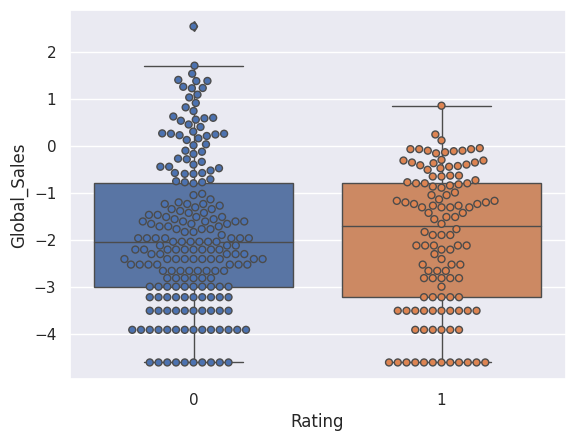

In [47]:
sns.boxplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1)
sns.swarmplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1);

In [48]:
result = reg.linear(data=df_rat_suc, formula='np.log(Global_Sales) ~ Rating')

In [49]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                 -0.002
Method:                   Least Squares   F-statistic:                    0.3760
Date:                  Fri, 25 Nov 2022   Prob (F-statistic):              0.540
Time:                          20:16:53   Log-Likelihood:                -592.00
No. Observations:                   323   AIC:                             1188.
Df Residuals:                       321   BIC:                             1196.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.8771      0.106    -17.712      0.000      -2.086      -1.669
Rating[T.1]    -0.1075      0.175     -0.613      0.540      -0.452       0.237
==============================================================================
Omnibus:                        9.464   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                5.966
Skew:                           0.172   Prob(JB):                       0.0506
Kurtosis:                       2.430   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
result.nano_summary()

-0.108 (0.175)


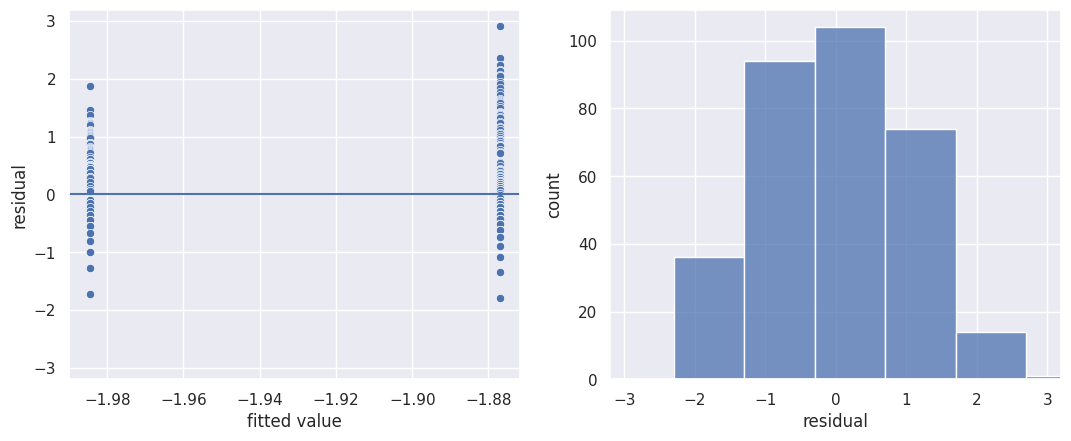

In [51]:
result.plot_residuals()